In [ ]:
pip install torch torchaudio librosa matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

Load and View a Sample Audio

100%|██████████| 331M/331M [00:10<00:00, 32.7MB/s]


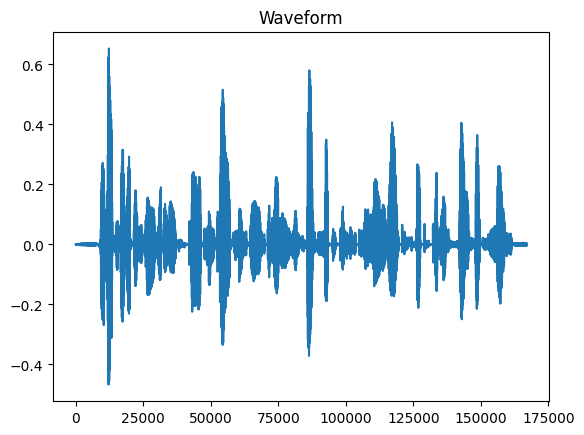

In [2]:
import torchaudio
import matplotlib.pyplot as plt

dataset = torchaudio.datasets.LIBRISPEECH('.', url='test-clean', download=True)
waveform, sample_rate, _, _, _, _ = dataset[0]

plt.plot(waveform[0].numpy())
plt.title('Waveform')
plt.show()

Convert WAV to Mel Spectrogram

In [10]:
import librosa
import numpy as np

def wav_to_mel_array(waveform, sr=22050, n_mels=80):
  y = waveform.numpy().squeeze()
  mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
  mel_db = librosa.power_to_db(mel, ref=np.max)

  #Normalize mel_db to range [0,1]
  mel_db_min = mel_db.min()
  mel_db_max = mel_db.max()
  mel_normalized = (mel_db - mel_db_min) / (mel_db_max - mel_db_min)


  # return mel_db
  return mel_normalized


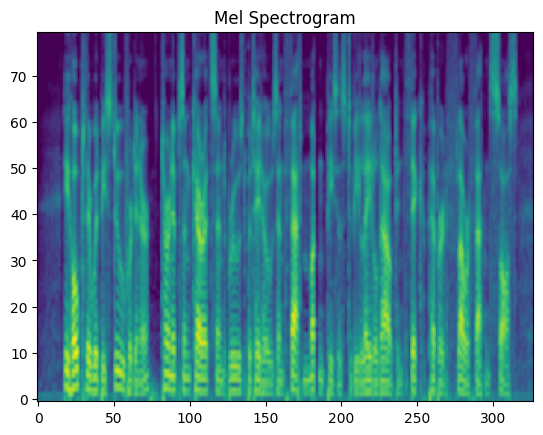

In [11]:
mel = wav_to_mel_array(waveform, sample_rate)
plt.imshow(mel, aspect='auto', origin='lower')
plt.title('Mel Spectrogram')
plt.show()

Define the VAE Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
  def __init__(self, input_dim=80*100,  hidden_dim=512, latent_dim=32):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc21 = nn.Linear(hidden_dim, latent_dim)
    self.fc22 = nn.Linear(hidden_dim, latent_dim)
    self.fc3 = nn.Linear(latent_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, input_dim)

  def encode(self, x):
    h = F.relu(self.fc1(x))
    return self.fc21(h), self.fc22(h)

  def reparam(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch. randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h))


  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparam(mu, logvar)
    return self.decode(z), mu, logvar



VAE Loss Function

In [13]:
def loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) -logvar.exp() )
  return BCE + KLD



Dataset and Dataloader

In [14]:
from torch.utils.data import Dataset, DataLoader

class MelDataset(Dataset):
  def __init__(self, waveforms, sr, n_mels=80, crop=100):
    self.data = []
    for wav in waveforms:
      mel = wav_to_mel_array(wav, sr, n_mels=n_mels)
      if mel.shape[1] >= crop:
        mel = mel[:, :crop]
        self.data.append(torch.tensor(mel).float().flatten())

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]





In [15]:
waveforms = [dataset[i][0] for i in range(10)]
sample_rate = dataset[0][1]
mel_dataset = MelDataset(waveforms, sample_rate)
loader = DataLoader(mel_dataset, batch_size=2, shuffle=True)



Train the VAE

In [16]:
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


for epoch in range(10):
  total_loss = 0

  for batch in loader:
    optimizer.zero_grad()
    recon_batch, mu, logvar = vae(batch)
    loss = loss_function(recon_batch, batch, mu, logvar)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f'Epoch {epoch+1} , Loss: {total_loss:.2f}')




Epoch 1 , Loss: 49772.26
Epoch 2 , Loss: 45863.10
Epoch 3 , Loss: 44632.64
Epoch 4 , Loss: 44101.33
Epoch 5 , Loss: 44083.34
Epoch 6 , Loss: 43622.64
Epoch 7 , Loss: 43629.65
Epoch 8 , Loss: 43311.55
Epoch 9 , Loss: 43246.60
Epoch 10 , Loss: 43616.20


Visualize Reconstructions

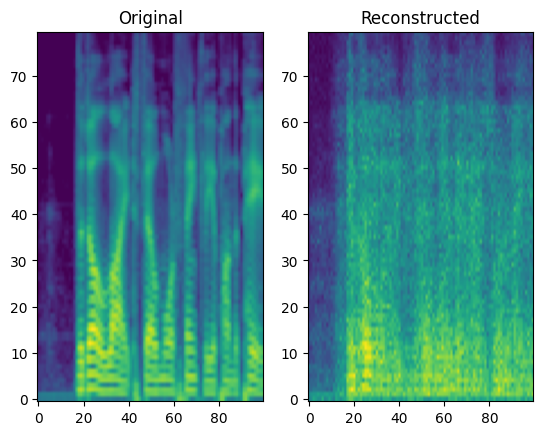

In [17]:
with torch.no_grad():
  batch = next(iter(loader))
  recon, _, _ = vae(batch)

  original = batch[0].view(80, -1).numpy()
  reconstructed = recon[0].view(80, -1).numpy()

  plt.subplot(1, 2, 1)
  plt.title('Original')
  plt.imshow(original, aspect='auto', origin='lower')


  plt.subplot(1,2, 2)
  plt.title('Reconstructed')
  plt.imshow(reconstructed, aspect='auto',origin='lower')

  plt.show()


Sample from Latent Space (Generate New Spectrograms)

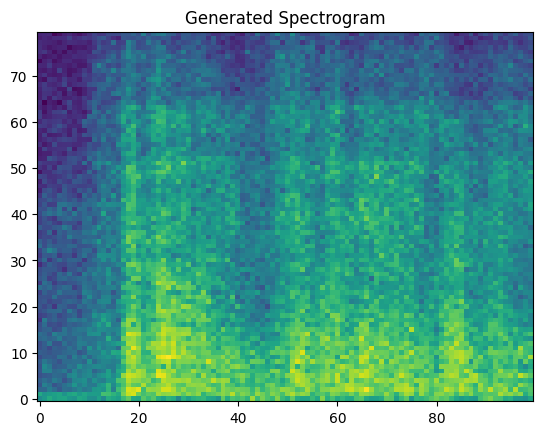

In [18]:
with torch.no_grad():
  z = torch.randn(1, 32)
  generated = vae.decode(z).view(80, -1).numpy()

  plt.title('Generated Spectrogram')
  plt.imshow(generated, aspect='auto', origin='lower')
  plt.show()

Reconstruct WAV from Mel Spectrogram

Install IPython Audio Player

In [19]:
from IPython.display import Audio


 Convert Mel Spectrogram to Audio using Griffin-Lim

In [20]:
import librosa
import librosa.display

def mel_to_audio(mel_db, sr=22050, n_iter=60):
  mel_power = librosa.db_to_power(mel_db)
  audio = librosa.feature.inverse.mel_to_audio(mel_power, sr=sr, n_iter=n_iter)
  return audio


Listen to Original and Reconstructed Audio

In [21]:
original = batch[0].view(80, -1).numpy()
reconstructed = recon[0].view(80, -1).numpy()

orig_audio = mel_to_audio(original)
recon_audio = mel_to_audio(reconstructed)



In [22]:
print('Original Audio')
Audio(orig_audio, rate=22050)



Original Audio


In [23]:
print('Reconstructed Audio')
Audio(recon_audio, rate=22050)


Reconstructed Audio


That looks like shit. Lets try with another audio file

In [24]:
!wget https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3 -O sample.mp3


--2025-04-13 08:36:28--  https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3
Resolving www.soundhelix.com (www.soundhelix.com)... 81.169.145.157, 2a01:238:20a:202:1157::
Connecting to www.soundhelix.com (www.soundhelix.com)|81.169.145.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8945229 (8.5M) [audio/mpeg]
Saving to: ‘sample.mp3’

sample.mp3          100%[===================>]   8.53M  8.39MB/s    in 1.0s    

2025-04-13 08:36:30 (8.39 MB/s) - ‘sample.mp3’ saved [8945229/8945229]



Convert to WAV

In [25]:
!apt install ffmpeg -y
!ffmpeg -i sample.mp3 -ar 16000 -ac 1 sample.wav

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq -

 Load the WAV as Your New Input

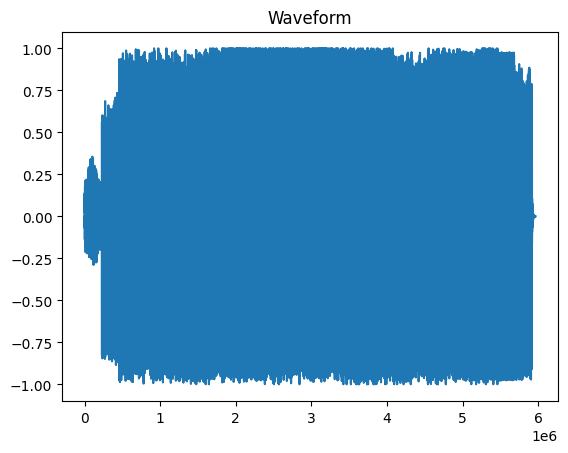

In [26]:
import librosa
import torch

y, sr = librosa.load('sample.wav', sr=16000)
waveform = torch.tensor(y).unsqueeze(0)

import matplotlib.pyplot as plt
plt.plot(waveform[0])
plt.title('Waveform')
plt.show()

Use This in Your Existing Workflow

In [27]:
mel = wav_to_mel_array(waveform, sr)
mel_cropped = mel[:, :100]


Crap. Lets do this once again

In [28]:
!wget https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3 -O sample.mp3


--2025-04-13 10:34:47--  https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3
Resolving www.soundhelix.com (www.soundhelix.com)... 81.169.145.157, 2a01:238:20a:202:1157::
Connecting to www.soundhelix.com (www.soundhelix.com)|81.169.145.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8945229 (8.5M) [audio/mpeg]
Saving to: ‘sample.mp3’

sample.mp3          100%[===================>]   8.53M  9.10MB/s    in 0.9s    

2025-04-13 10:34:48 (9.10 MB/s) - ‘sample.mp3’ saved [8945229/8945229]



In [29]:
!apt install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
!ffmpeg -i sample.mp3 -ar 16000 -ac 1 sample.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

 Load WAV and Convert to Mel Spectrogram

In [ ]:
import librosa
import torch

y,sr = librosa.load('sample.wav', sr=16000)
waveform = torch.tensor(y).unsqueeze(0)

mel =  wav_to_mel_array(waveform, sr=16000)


mel = mel[:, :100]
mel_tensor = torch.tensor(mel).float().flatten().unsqueeze(0)

Reconstruct Using the VAE

In [ ]:
vae.eval()

with torch.no_grad():
  recon_tensor, mu, logvar = vae(mel_tensor)
